In [10]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

3000 <class 'int'>


100%|██████████| 3000/3000 [00:00<00:00, 47450.46it/s]


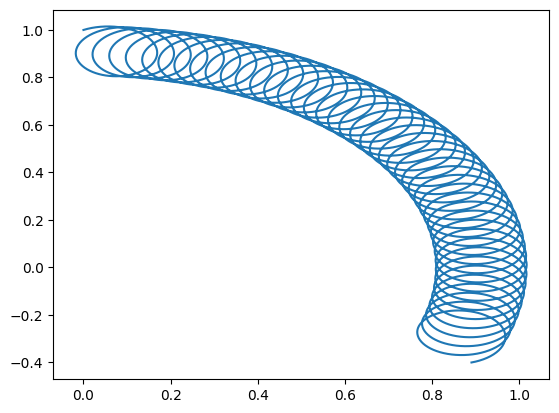

1000000 <class 'int'>


100%|██████████| 1000000/1000000 [00:11<00:00, 87400.55it/s]


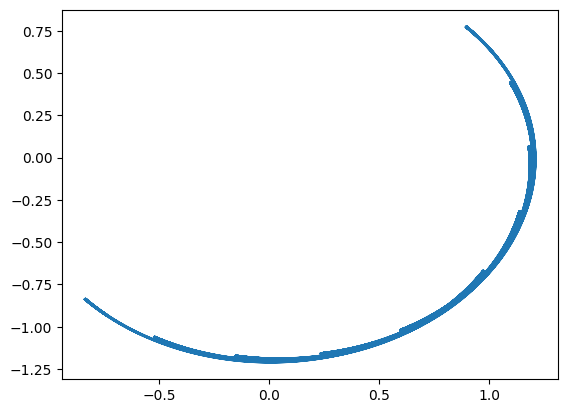

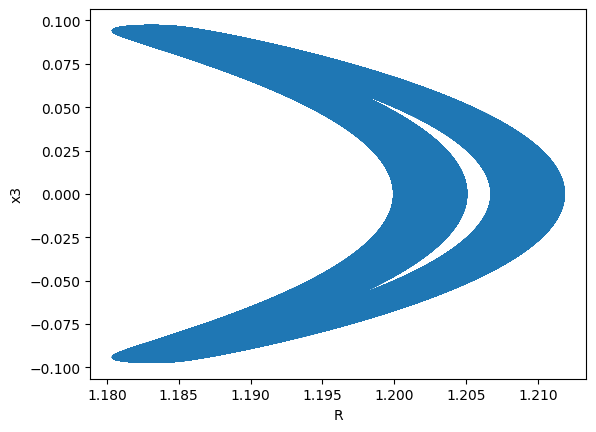

In [ ]:
# ========== BORIS METHOD ==========

def cross(a, b):
    return np.array([a[1]*b[2]-a[2]*b[1],
                     a[2]*b[0]-a[0]*b[2],
                     a[0]*b[1]-a[1]*b[0]], dtype=np.float32)

def boris_update(x, v, B, dU, h):
    B_val = B(x)
    E_val = dU(x)

    v_minus = v + (h*0.5) * E_val
    t       = 0.5*h * B_val
    t_dot_t = t[0] * t[0] + t[1] * t[1] + t[2] * t[2]
    s       = 2.0  * t / (1.0 + t_dot_t)

    v_prime = v_minus + cross(v_minus, t)
    v_plus  = v_minus + cross(v_prime, s)
    v[:]    = v_plus + (h*0.5) * E_val
    x[:]    = x + h * v           

def init_v_minus_half(x0, v0, B, dU, h):
    B_val = B(x0)
    E_val = dU(x0)

    a = np.cross(v0, B_val) - E_val
    return v0 - 0.5*h * a

def B_2D(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    return np.array([0.0, 0.0, r], dtype=np.float32)

def dU_2D(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    invr = 0.0 if r == 0.0 else 1.0/r
    return np.array([0.01*x[0]*invr, 0.01*x[1]*invr, 0.0], dtype=np.float32)

def B_tokamak(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    inv2r2 = 0.5 / r2
    inv2r  = 0.5 / r
    Bx = -(2.0*x[1] + x[0]*x[2]) * inv2r2
    By =  (2.0*x[0] - x[1]*x[2]) * inv2r2
    Bz = (r - 1.0) * inv2r
    return np.array([Bx, By, Bz], dtype=np.float32)

def dU_tokamak(x):
    return np.zeros(3, dtype=np.float32)

def integrate_boris(x0, v_minus_half, nsteps, B, dU, h):
    X = np.empty((nsteps+1, 3), dtype=np.float32)
    V = np.empty((nsteps+1, 3), dtype=np.float32)
                        
    x = x0.copy()
    v = v_minus_half.copy()
    X[0, :] = x
    V[0, :] = v

    print(nsteps, type(nsteps))
    for i in trange(1, nsteps+1):
        boris_update(x, v, B, dU, h)
        X[i, :] = x
        V[i, :] = v

    return X, V

# 2D charged particle
h      = 0.1
T_max  = 1e5
nsteps = int(T_max / h)

x0 = np.array([0.0, 1.0, 0.1])
v0 = np.array([0.09, 0.05, 0.20])

v_mhalf = init_v_minus_half(x0, v0, B_2D, dU_2D, h)
X_vals, V_vals = integrate_boris(x0, v_mhalf, nsteps, B_2D, dU_2D, h)

plt.figure()
plt.plot(X_vals[:,0], X_vals[:,1])
plt.show()

# Tokamak magnetic field
h      = 0.1
T_max  = 1e5
nsteps = int(T_max / h)

x0 = np.array([1.2, 0.0, 0.0])
v0 = np.array([0, 4.816e-4, -2.059e-3])

v_mhalf = init_v_minus_half(x0, v0, B_tokamak, dU_tokamak, h)
X_vals, Y_vals = integrate_boris(x0, v0, nsteps, B_tokamak, dU_tokamak, h)

plt.figure()
plt.plot(X_vals[:,0], X_vals[:, 1])
plt.show()

R = np.sqrt(X_vals[:,0]**2 + X_vals[:,1]**2)
plt.figure()
plt.plot(R, X_vals[:,2])
plt.xlabel('R'); plt.ylabel('x3')
plt.show()
